In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [2]:
#downloadData & providePath
dataLink = '../input/mitbiharrhythmiadatabase100/mit-bih-arrhythmia-database-1.0.0/'

In [3]:
#makeListOfAllPatients
patients = ["100", "101", "102", "103", "104", "105", "106", "107",
            "108", "109", "111", "112", "113", "114", "115", "116",
            "117", "118", "119", "121", "122", "123", "124", "200",
            "201", "202", "203", "205", "207", "208", "209", "210",
            "212", "213", "214", "215", "217", "219", "220", "221",
            "222", "223", "228", "230", "231", "232",  "233","234"]

In [4]:
#useForLoadingECG&Annotations
import wfdb 

In [5]:
#createDataFrame
dataFrame = pd.DataFrame()

for patient in patients:
    data = dataLink + patient #loadAllAnnotations
    annot = wfdb.rdann(data, "atr") #annotation
    symbol = annot.symbol
    values, number = np.unique(symbol, return_counts = True)
    subDataFrame = pd.DataFrame({"Symbol" : values, "Number" : number, "Patient" : [patient] * len(number)})
    dataFrame = pd.concat([dataFrame, subDataFrame],axis = 0)

In [6]:
#distibutionOfHeartBeatTypes
dataFrame.groupby("Symbol").Number.sum().sort_values(ascending = False)

Symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Number, dtype: int64

In [7]:
nonBeat = ['[' , '!' , ']' , 'x' , '(' , ')' , 'p' , 't' , 'u' ,'`', '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ["L" , "R" , "V" , "/" , "A" , "f" , "F" , "j" , "a" , "E" , "J" , "e" , "S"]

In [8]:
dataFrame["category"] = -1 #nonbeat
dataFrame.loc[dataFrame.Symbol == "N" , "category"] = 0 #normal
dataFrame.loc[dataFrame.Symbol.isin(abnormal), "category"] = 1 #abnormal

In [9]:
#distributionOfNormal,Abnormal&NonBeat
dataFrame.groupby("category").Number.sum()

category
-1     3186
 0    75052
 1    34409
Name: Number, dtype: int64

In [10]:
def loadEcg(data): #loadSinglePattientSignal&Annotation
    ecg = wfdb.rdrecord(data) #loadECG
    annot = wfdb.rdann(data, "atr")
    pSignal = ecg.p_signal #getSignal

    assert ecg.fs == 360, "Sample Frequency Is Not 360"
    atrSymbol = annot.symbol #getSymbol
    atrSample = annot.sample #getAnnotatioIndex
    
    return pSignal, atrSymbol, atrSample

In [11]:
data = dataLink + patients[0]

In [12]:
pSignal, atrSymbol, atrSample = loadEcg(data)

In [14]:
values, counts = np.unique(symbol, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [15]:
values, number= np.unique(symbol, return_counts = True)
for val,num in zip(values, number):
    print(val,num) #abnormalBeats&TheirNumber

+ 3
J 50
N 2700
V 3
~ 8


In [16]:
indexOfAbnormal = [y for x , y in zip(atrSymbol,atrSample) if x in abnormal][:10] #getIndexOfAbnormalBeat
indexOfAbnormal

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [17]:
a = np.arange(len (pSignal) )

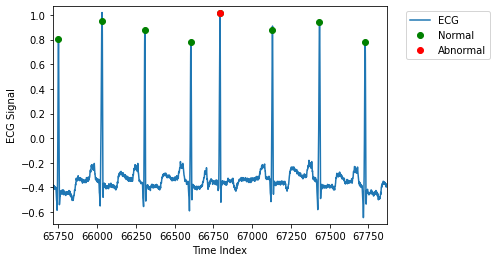

In [18]:
l = indexOfAbnormal[1] - 1080 #left
r = indexOfAbnormal[1] + 1080 #right

plt.ylabel("ECG Signal")
plt.xlabel("Time Index")

plt.plot(a[l : r] , pSignal[l : r , 0] , "-" , label = "ECG",)
plt.plot(a[atrSample] , pSignal[atrSample , 0] , "go" , label = "Normal")
plt.plot(a[indexOfAbnormal] , pSignal[indexOfAbnormal , 0] , "ro" , label = "Abnormal")

plt.xlim(l , r)
plt.ylim(pSignal[l : r].min() - 0.05 , pSignal[l : r , 0].max() + 0.05)

plt.legend(bbox_to_anchor = (1.04 , 1) , loc = "upper left")
plt.show()

In [19]:
def makeXY(pSignal, annotDataFrame, numOfColumns, abnormal):
    symbols = []
    maxRow = 0
    numOfRows = len(annotDataFrame)
    
    X = np.zeros((numOfRows , numOfColumns))
    Y = np.zeros((numOfRows , 1))
    
    for atrSample, atrSymbol in zip(annotDataFrame.atrSample.values,annotDataFrame.atrSymbol.values):
        l = max([0 , (atrSample - frequency * numOfSecond)]) #left
        r = min([len(pSignal) , (atrSample + frequency * numOfSecond)]) #right
        x = pSignal[l : r]
        if len(x) == numOfColumns:
            X[maxRow,:] = x
            Y[maxRow,:] = int(atrSymbol in abnormal)
            symbols.append(atrSymbol)
            maxRow = maxRow + 1
    X = X[:maxRow,:]
    Y = Y[:maxRow,:]
    return X , Y , symbols

In [20]:
def createDataSet(patients, numOfSecond, frequency, abnormal): #ignoreNonBeats
    allSymbols = []
    max_rows = [] #ListOfNumOfBeatsForPatient
    numOfColumns = frequency * numOfSecond * 2
    allX = np.zeros((1 , numOfColumns))
    allY = np.zeros((1,1))

    for patient in patients:
        data = dataLink + patient
        pSignal, atrSymbol, atrSample = loadEcg(data)
        pSignal = pSignal[: , 0] #getFirstSignal
        # createDataFrame
        annotDataFrame = pd.DataFrame({"atrSymbol":atrSymbol , "atrSample" : atrSample})
        annotDataFrame = annotDataFrame.loc[annotDataFrame.atrSymbol.isin(abnormal + ["N"])] #excludeNonBeats
    
        X , Y , symbol = makeXY(pSignal, annotDataFrame, numOfColumns, abnormal)
        allSymbols = symbol + allSymbols 
        max_rows.append(X.shape[0])
        allX = np.append(allX , X , axis = 0)
        allY = np.append(allY , Y , axis = 0)
 
    allX = allX[1 : , :]
    allY = allY[1 : , :]

    return allX, allY, allSymbols

In [21]:
numOfSecond = 3
frequency = 360

In [22]:
allX, allY, sym_all = createDataSet(patients, numOfSecond, frequency, abnormal)

In [23]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(allX, allY, test_size=0.10, random_state=42)

In [24]:
import random
random.seed( 42 )
train = random.sample(patients, 36)
test = [patient for patient in patients if patient not in train]
print(len(train) , len(test))

36 12


In [25]:
Xtrain, Ytrain, trainSymbol = createDataSet(train, numOfSecond, frequency, abnormal)
Xtest, Ytest, testSymbol = createDataSet(test, numOfSecond, frequency, abnormal)
print(Xtrain.shape, Ytrain.shape, len(trainSymbol))
print(Xtest.shape, Ytest.shape, len(testSymbol))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def prevCalc(actualY):
    return (sum(actualY) / len(actualY))

def specifCal(actualY, predictedY, threshold):
    return sum((threshold > predictedY) & (actualY == 0)) / sum(actualY ==0 )

def showReport(actualY, predictedY, threshold):
    
    AUC = roc_auc_score(actualY, predictedY)
    accuracy = accuracy_score(actualY, (predictedY > threshold))
    sensitivity = recall_score(actualY, (predictedY > threshold))
    specificity = specifCal(actualY, predictedY, threshold)
    precision = precision_score(actualY, (predictedY > threshold))
    prevalence = prevCalc(actualY)
    
    print("AUC - %.3f"%AUC)
    print("Accuracy - %.3f"%accuracy)
    print("Sensitivity - %.3f"%sensitivity)
    print("Specificity - %.3f"%specificity)
    print("Precision - %.3f"%precision)
    print("Prevalence - %.3f"%prevalence)
    print(" ")
    
    return AUC , accuracy , sensitivity , specificity, precision 

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [28]:
######## D E N S E ########
model = Sequential()
model.add(Dense(32 , activation = "relu" , input_dim = Xtrain.shape[1]))
model.add(Dropout(rate = 0.25)) #addDropOut
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy" , optimizer = "adam" , metrics = ["accuracy"])
model.fit(Xtrain, Ytrain, batch_size = 32, epochs = 5, verbose = 1)

Epoch 1/5
2520/2520 [==============================] - 7s 2ms/step - loss: 0.3094 - accuracy: 0.8802
Epoch 2/5
2520/2520 [==============================] - 6s 2ms/step - loss: 0.1441 - accuracy: 0.9569
Epoch 3/5
2520/2520 [==============================] - 6s 2ms/step - loss: 0.1309 - accuracy: 0.9627
Epoch 4/5
2520/2520 [==============================] - 6s 2ms/step - loss: 0.1079 - accuracy: 0.9689
Epoch 5/5
2520/2520 [==============================] - 6s 2ms/step - loss: 0.1076 - accuracy: 0.9701


In [29]:
denseTrainPred = model.predict_proba(Xtrain , verbose = 1)
denseTestPred = model.predict_proba(Xtest , verbose = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


891/891 [==============================] - 1s 1ms/step


In [30]:
threshold = (sum(Ytrain) / len(Ytrain))[0]
threshold

0.29906715955045027

In [31]:
print("Train");
showReport(Ytrain , denseTrainPred , threshold)
print("Test");
showReport(Ytest , denseTestPred , threshold);

Train
AUC - 0.993
Accuracy - 0.975
Sensitivity - 0.960
Specificity - 0.982
Precision - 0.958
Prevalence - 0.299
 
Test
AUC - 0.870
Accuracy - 0.778
Sensitivity - 0.454
Specificity - 0.958
Precision - 0.859
Prevalence - 0.358
 


In [32]:
######## C N N ########

In [33]:
XtrainCNN = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1)) #reshapingInput
XtestCNN = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))
print(XtrainCNN.shape)
print(XtestCNN.shape)

(80614, 2160, 1)
(28485, 2160, 1)


In [34]:
from keras.layers import Conv1D
from keras.layers import Dropout

In [35]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu", input_shape = (2160,1)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [36]:
BS = 32
epochs = 2
verbose = 1
model.fit(XtrainCNN, Ytrain, BS, epochs, verbose)

Epoch 1/2
2520/2520 [==============================] - 14s 5ms/step - loss: 0.2738 - accuracy: 0.8989
Epoch 2/2
2520/2520 [==============================] - 11s 5ms/step - loss: 0.1323 - accuracy: 0.9611


In [37]:
from keras.models import model_from_json
from keras.models import load_model

#Saving&LoadingModel&Weights

modelJson = model.to_json() #serializeModelToJSON

with open("model_num.json", "w") as jsonFile:
    jsonFile.write(modelJson)

model.save_weights("model_num.h5") #serializeWeightsToHDF5

In [38]:
# load json and create model
jsonFile = open("model_num.json" , "r")

loadedModelJson = jsonFile.read()
jsonFile.close()
loadedModel = model_from_json(loadedModelJson)

loadedModel.load_weights("model_num.h5") #loadingWeightsToNewModel
print("Loaded model from disk")

loadedModel.save("model_num.hdf5")
loadedModel = load_model("model_num.hdf5")

Loaded model from disk


In [39]:
cnnTrainPred = loadedModel.predict_proba(XtrainCNN , verbose)
cnnTestPred = loadedModel.predict_proba(XtestCNN , verbose)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [40]:
print("Train");
showReport(Ytrain, cnnTrainPred, threshold)
print("Test");
showReport(Ytest, cnnTestPred, threshold);

Train
AUC - 0.991
Accuracy - 0.971
Sensitivity - 0.953
Specificity - 0.979
Precision - 0.951
Prevalence - 0.299
 
Test
AUC - 0.906
Accuracy - 0.834
Sensitivity - 0.747
Specificity - 0.883
Precision - 0.780
Prevalence - 0.358
 


In [41]:
######## L S T M ########

In [42]:
from keras.layers import Bidirectional, LSTM

In [43]:
mod = Sequential()
mod.add(Bidirectional(LSTM(64 , input_shape = (XtrainCNN.shape[1], XtrainCNN.shape[2]))))
mod.add(Dropout(rate = 0.5))
mod.add(Dense(1 , activation = "sigmoid"))
mod.compile( loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [44]:
epochs = 5
mod.fit(XtrainCNN, Ytrain, BS, epochs, verbose)

Epoch 1/5
2520/2520 [==============================] - 331s 130ms/step - loss: 0.6037 - accuracy: 0.7027
Epoch 2/5
2520/2520 [==============================] - 331s 131ms/step - loss: 0.6046 - accuracy: 0.7023
Epoch 3/5
2520/2520 [==============================] - 332s 132ms/step - loss: 0.5975 - accuracy: 0.6989
Epoch 4/5
2520/2520 [==============================] - 333s 132ms/step - loss: 0.5995 - accuracy: 0.7006
Epoch 5/5
2520/2520 [==============================] - 332s 132ms/step - loss: 0.5883 - accuracy: 0.7045


In [ ]:
lstmTrainPred = mod.predict_proba(XtrainCNN,verbose)
lstmTestPred = mod.predict_proba(XtestCNN,verbose)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
print("Train");
print_report(y_train, lstmTrainPred, thresh)
print("Test");
print_report(Ytest, lstmTrainPred, thresh);